# Holt-Winters Forecasting

In the next few examples we are going to be using this tiny series:

In [16]:
import matplotlib.pyplot as plt
%matplotlib notebook

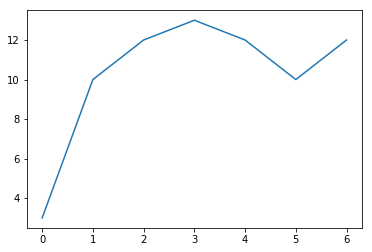

In [35]:
series = [3,10,12,13,12,10,12]
x = range(len(series))
plt.plot(x,series)

## Simple Average

In [18]:
def average(series):
    return float(sum(series))/len(series)

# Given the above series, the average is:
average(series)

10.285714285714286

## Moving Average

In [19]:
# moving average using n last points
def moving_average(series, n):
    return average(series[-n:])

In [20]:
moving_average(series, 3)

11.333333333333334

In [21]:
moving_average(series, 4)

11.75

In [22]:
def average(series, n=None):
    if n is None:
        return average(series, len(series))
    return float(sum(series[-n:]))/n

In [23]:
average(series, 3)

11.333333333333334

In [24]:
average(series)

10.285714285714286

## Weighted Moving Average

In [25]:
# weighted average, weights is a list of weights
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

In [26]:
weights = [0.1, 0.2, 0.3, 0.4]
weighted_average(series, weights)

11.500000000000002

I would also like to stress the importance of the weights adding up to 1. To demonstrate why, let’s say we pick weights [0.9, 0.8, 0.7, 0.6] (which add up to 3.0). Watch what happens:

In [27]:
weighted_average(series, [0.9, 0.8, 0.7, 0.6])

35.5

## Single Exponential Smoothing

In [28]:
# given a series and alpha, return series of smoothed points
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

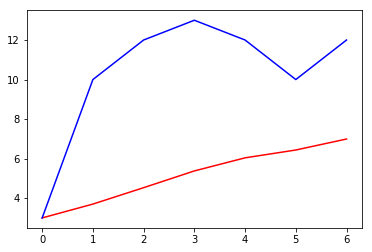

In [36]:
plt.plot(x, exponential_smoothing(series, 0.1), 'r', x, series, 'b')

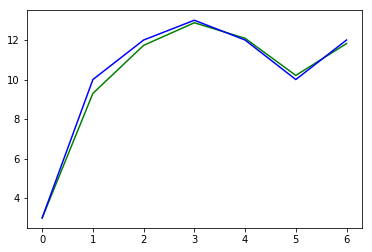

In [37]:
plt.plot(x, exponential_smoothing(series, 0.9),'g', x, series, 'b')

## Double Exponential Smoothing

In [38]:
# given a series and alpha, return series of smoothed points
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # we are forecasting
          value = result[-1]
        else:
          value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

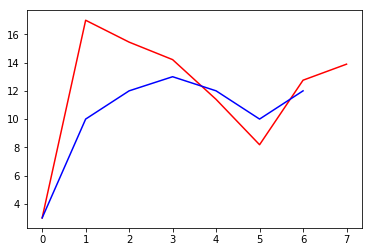

In [41]:
plt.plot(double_exponential_smoothing(series, alpha=0.9, beta=0.9), 'r', series, 'b')

## Triple Exponential Smoothing a.k.a Holt-Winters Method

In [60]:
series = [30,21,29,31,40,48,53,47,37,39,31,29,17,9,20,24,27,35,41,38,
          27,31,27,26,21,13,21,18,33,35,40,36,22,24,21,20,17,14,17,19,
          26,29,40,31,20,24,18,26,17,9,17,21,28,32,46,33,23,28,22,27,
          18,8,17,21,31,34,44,38,31,30,26,32]
s_len=len(series)

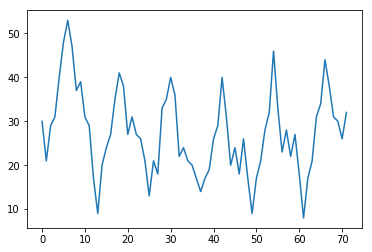

In [43]:
plt.plot(series)

In [49]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

In [50]:
initial_trend(series, 12)

-0.7847222222222222

In [44]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

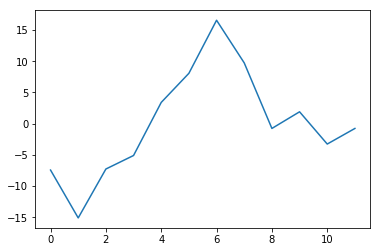

In [58]:
result=initial_seasonal_components(series, 12)
result=list(result.values())
plt.plot(result)

In [46]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [63]:
result = triple_exponential_smoothing(series, 12, 0.716, 0.029, 0.993, 24)
r_len=len(result)

In [68]:
len(range(s_len))


72

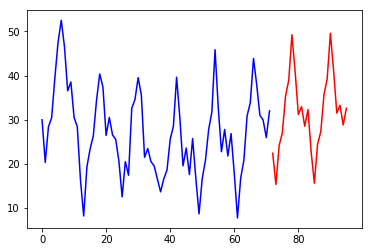

In [74]:
observed_x = range(s_len)
observed_y = result[:s_len]
expected_x = list(range(r_len))[s_len:]
expected_y = result[s_len:]
plt.plot(observed_x, observed_y,'b',expected_x,expected_y,'r')